In [1]:
%load_ext autoreload
%autoreload 2

In [109]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np
import seaborn as sns

root_path = Path().resolve().parents[1]
enrollment_2022_path = root_path / 'data' / 'enrollment_2022'
map_path = root_path / 'data' / 'NYS_Civil_Boundaries'

In [53]:
enrollment_data = pd.read_csv(enrollment_2022_path / 'enrollment_2022.csv')
demographic_data = pd.read_csv(enrollment_2022_path / 'demographic_factors_2022.csv')
boces_nrc_data = pd.read_csv(enrollment_2022_path / 'boces_nrc_2022.csv')
county_data = gp.read_file(map_path / "Counties.shp")
county_data["NAME"] = county_data["NAME"].str.upper()

In [139]:
# demographic_data.merge(boces_nrc_data, how="right", left_on="ENTITY_CD", right_on="ENTITY_CD")
data = (demographic_data[demographic_data["YEAR"] == 2022]
 .merge(boces_nrc_data[boces_nrc_data["YEAR"] == 2022], how="left", left_on="ENTITY_CD", right_on="ENTITY_CD")
 .merge(enrollment_data[["YEAR", "ENTITY_CD", "K12"]].query("YEAR == 2022"), how="left", left_on="ENTITY_CD", right_on="ENTITY_CD")
 .dropna()
)


def get_exposure(county_name, pop_1, pop_2, renormalize=True):
  county_data = data[data["COUNTY_NAME"] == county_name]
  p_A = county_data[pop_1] / county_data[pop_1].sum()
  prop_B = county_data[pop_2] / county_data["K12"]
  score = (prop_B * p_A).sum()
  if renormalize:
    score = score * (county_data["K12"].sum() / county_data[pop_2].sum())
    # score = score - (county_data[pop_2].sum() / county_data["K12"].sum())
  return score

def get_exposure_mat(county_name, pop_list, renormalize=True):
  E = np.zeros((len(pop_list), len(pop_list)))
  for i, pop_1 in enumerate(pop_list):
    for j, pop_2 in enumerate(pop_list):
      E[i, j] = get_exposure(county_name, pop_1, pop_2, renormalize)
  return E

racial_pops = ["AM_IND", "BLACK", "HISP", "ASIAN", "WHITE", "Multi"]
racial_pops_prefixed = list(map(lambda s: "NUM_" + s, racial_pops))

E = get_exposure_mat("WESTCHESTER", racial_pops_prefixed, renormalize=True)
# data.COUNTY_NAME.unique()

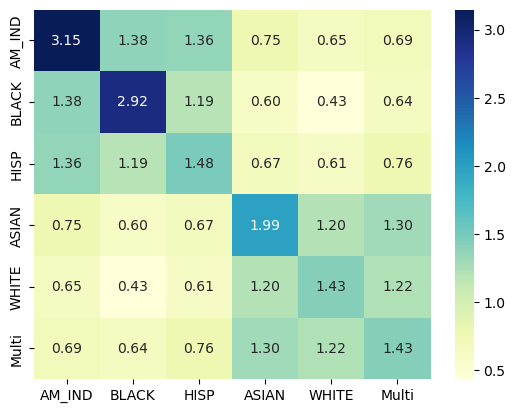

In [140]:
fig, ax = plt.subplots()

sns.heatmap(E, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")

ax.set(xticklabels=racial_pops, yticklabels= racial_pops)
plt.show()

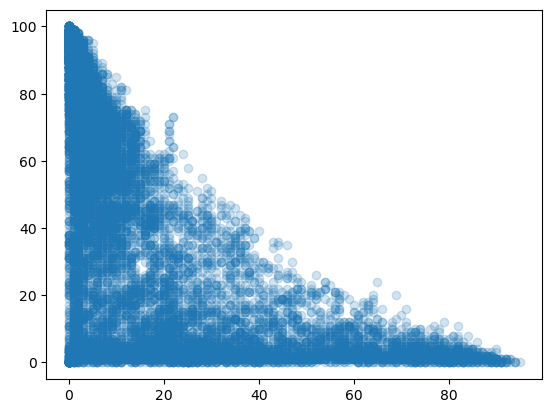

In [25]:
plt.scatter(data=demographic_data, x="PER_BLACK", y="PER_WHITE", alpha=0.2)